# DBSCAN AND K_MEANS

In [80]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load and scale data
df = pd.read_csv('final_data.csv')
features = df.drop(columns=['Food Name'])
scaler = StandardScaler()
X = scaler.fit_transform(features.values)

# ---------- K-MEANS ----------
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

# Evaluation
kmeans_silhouette = silhouette_score(X, kmeans_labels)
kmeans_db_score = davies_bouldin_score(X, kmeans_labels)
print(f"[KMeans] Silhouette Score: {kmeans_silhouette:.4f}")
print(f"[KMeans] Davies-Bouldin Score: {kmeans_db_score:.4f}")

# ---------- DBSCAN ----------
dbscan = DBSCAN(eps=2.0, min_samples=5)  # tune eps
dbscan_labels = dbscan.fit_predict(X)

# Filter out noise points
mask = dbscan_labels != -1
if len(np.unique(dbscan_labels[mask])) > 1:
    dbscan_silhouette = silhouette_score(X[mask], dbscan_labels[mask])
    dbscan_db_score = davies_bouldin_score(X[mask], dbscan_labels[mask])
    print(f"[DBSCAN] Silhouette Score: {dbscan_silhouette:.4f}")
    print(f"[DBSCAN] Davies-Bouldin Score: {dbscan_db_score:.4f}")
else:
    print("[DBSCAN] Not enough clusters to evaluate metrics.")

# ---------- Recommendation Logic ----------
def recommend_similar_foods(food_name, method='kmeans', top_n=5):
    try:
        idx = df[df['Food Name'] == food_name].index[0]
    except IndexError:
        print(f"Food '{food_name}' not found.")
        return []

    cluster_label = kmeans_labels[idx] if method == 'kmeans' else dbscan_labels[idx]

    if cluster_label == -1:
        print(f"'{food_name}' is labeled as noise in DBSCAN.")
        return []

    indices = np.where((kmeans_labels if method == 'kmeans' else dbscan_labels) == cluster_label)[0]
    distances = np.linalg.norm(X[indices] - X[idx], axis=1)
    sorted_indices = indices[np.argsort(distances)]
    recommended_names = df.iloc[sorted_indices[1:top_n+1]]['Food Name'].values

    return recommended_names

# Example recommendation
food = df['Food Name'].iloc[0]
print(f"\nTop 5 similar foods to '{food}' (KMeans):")
print(recommend_similar_foods(food, method='kmeans'))

print(f"\nTop 5 similar foods to '{food}' (DBSCAN):")
print(recommend_similar_foods(food, method='dbscan'))


[KMeans] Silhouette Score: 0.2242
[KMeans] Davies-Bouldin Score: 1.9031
[DBSCAN] Silhouette Score: -0.0640
[DBSCAN] Davies-Bouldin Score: 0.8369

Top 5 similar foods to 'APPLEBEE'S, 9 oz house sirloin steak' (KMeans):
['Restaurant, family style, sirloin steak'
 'Sausage, turkey, fresh, cooked' 'CRACKER BARREL, grilled sirloin steak'
 'Sausage, turkey, fresh, raw'
 "T.G.I. FRIDAY'S, classic sirloin steak (10 oz)"]

Top 5 similar foods to 'APPLEBEE'S, 9 oz house sirloin steak' (DBSCAN):
['Restaurant, family style, sirloin steak'
 'Sausage, turkey, fresh, cooked' 'CRACKER BARREL, grilled sirloin steak'
 'Sausage, turkey, fresh, raw'
 "T.G.I. FRIDAY'S, classic sirloin steak (10 oz)"]


# AUTO ENCODERS

Epoch 1/50, Train Loss: 0.6198, Val Loss: 0.5041
Epoch 2/50, Train Loss: 0.3471, Val Loss: 0.3756
Epoch 3/50, Train Loss: 0.2548, Val Loss: 0.2991
Epoch 4/50, Train Loss: 0.1952, Val Loss: 0.2629
Epoch 5/50, Train Loss: 0.1576, Val Loss: 0.2121
Epoch 6/50, Train Loss: 0.1276, Val Loss: 0.1846
Epoch 7/50, Train Loss: 0.1117, Val Loss: 0.1688
Epoch 8/50, Train Loss: 0.0893, Val Loss: 0.1505
Epoch 9/50, Train Loss: 0.0757, Val Loss: 0.1410
Epoch 10/50, Train Loss: 0.0671, Val Loss: 0.1180
Epoch 11/50, Train Loss: 0.0572, Val Loss: 0.1064
Epoch 12/50, Train Loss: 0.0652, Val Loss: 0.0951
Epoch 13/50, Train Loss: 0.0609, Val Loss: 0.0834
Epoch 14/50, Train Loss: 0.0457, Val Loss: 0.0835
Epoch 15/50, Train Loss: 0.0371, Val Loss: 0.0639
Epoch 16/50, Train Loss: 0.0331, Val Loss: 0.0612
Epoch 17/50, Train Loss: 0.0315, Val Loss: 0.0722
Epoch 18/50, Train Loss: 0.0332, Val Loss: 0.0864
Epoch 19/50, Train Loss: 0.0301, Val Loss: 0.0478
Epoch 20/50, Train Loss: 0.0215, Val Loss: 0.0467
Epoch 21/

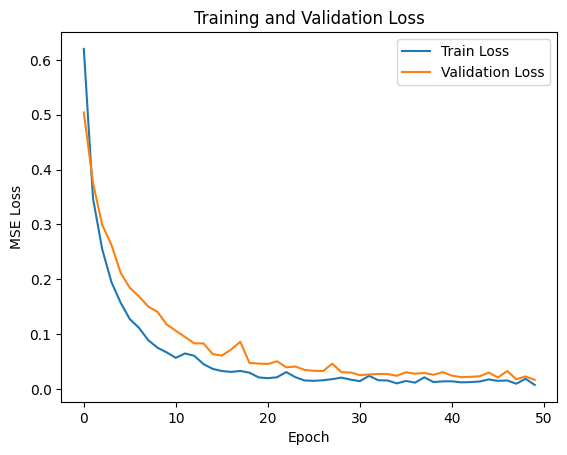

Overall Reconstruction MSE: 0.0073


In [81]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Load dataset
df = pd.read_csv('final_data.csv')

# Separate features and scale
features = df.drop(columns=['Food Name'])
scaler = StandardScaler()
X = scaler.fit_transform(features.values)

# Convert to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)

# Create dataset and split
dataset = TensorDataset(X_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

# Define autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize model
input_dim = X.shape[1]
model = Autoencoder(input_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 50
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        data = batch[0]
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            data = batch[0]
            output = model(data)
            loss = criterion(output, data)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Plot losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Evaluate model
model.eval()
with torch.no_grad():
    reconstructed = model(X_tensor)
    mse = mean_squared_error(X_tensor.numpy(), reconstructed.numpy())
    print(f"Overall Reconstruction MSE: {mse:.4f}")

# Plot coefficient matrix (weights of first encoder layer)
weights = model.encoder[0].weight.data.numpy()

# plt.figure(figsize=(12, 8))
# sns.heatmap(weights, cmap='coolwarm', xticklabels=features.columns, yticklabels=[f"Enc_{i}" for i in range(weights.shape[0])])
# plt.title('Encoder First Layer Weights (Coefficient Matrix)')
# plt.xlabel('Input Features')
# plt.ylabel('Hidden Units')
# plt.show()


In [85]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics.pairwise import cosine_similarity
import torch.nn.functional as F

# Convert tensors to NumPy arrays
original = X_tensor.numpy()
reconstructed_np = reconstructed.numpy()

# Basic regression metrics
mse = mean_squared_error(original, reconstructed_np)
mae = mean_absolute_error(original, reconstructed_np)
rmse = np.sqrt(mse)
r2 = r2_score(original, reconstructed_np)

# Cosine similarity between original and reconstructed vectors (per sample)
cosine_sim_recon = np.mean([
    cosine_similarity([x], [y])[0][0]
    for x, y in zip(original, reconstructed_np)
])

# Cosine similarity in latent space
with torch.no_grad():
    encoded = model.encoder(X_tensor)
    encoded_np = encoded.numpy()
    latent_cosine_sim = np.mean([
        cosine_similarity([x], [y])[0][0]
        for x, y in zip(encoded_np, encoded_np)
    ])  # Note: this just shows overall similarity across encoded vectors

# Print all results
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Cosine Similarity (Reconstruction): {cosine_sim_recon:.4f}")



MSE: 0.0163
MAE: 0.0554
RMSE: 0.1278
R² Score: 0.9837
Cosine Similarity (Reconstruction): 0.9962


# DIFFUSION AUTOENCODERS

Epoch 1/50, Train Loss: 0.7117, Val Loss: 0.3538
Epoch 2/50, Train Loss: 0.4142, Val Loss: 0.2360
Epoch 3/50, Train Loss: 0.2977, Val Loss: 0.1712
Epoch 4/50, Train Loss: 0.2322, Val Loss: 0.1483
Epoch 5/50, Train Loss: 0.1854, Val Loss: 0.1139
Epoch 6/50, Train Loss: 0.1426, Val Loss: 0.0883
Epoch 7/50, Train Loss: 0.1070, Val Loss: 0.0749
Epoch 8/50, Train Loss: 0.0926, Val Loss: 0.0654
Epoch 9/50, Train Loss: 0.0740, Val Loss: 0.0745
Epoch 10/50, Train Loss: 0.0812, Val Loss: 0.0527
Epoch 11/50, Train Loss: 0.0729, Val Loss: 0.0528
Epoch 12/50, Train Loss: 0.0666, Val Loss: 0.0453
Epoch 13/50, Train Loss: 0.0509, Val Loss: 0.0462
Epoch 14/50, Train Loss: 0.0534, Val Loss: 0.0487
Epoch 15/50, Train Loss: 0.0497, Val Loss: 0.0360
Epoch 16/50, Train Loss: 0.0409, Val Loss: 0.0301
Epoch 17/50, Train Loss: 0.0341, Val Loss: 0.0350
Epoch 18/50, Train Loss: 0.0336, Val Loss: 0.0248
Epoch 19/50, Train Loss: 0.0353, Val Loss: 0.0264
Epoch 20/50, Train Loss: 0.0305, Val Loss: 0.0222
Epoch 21/

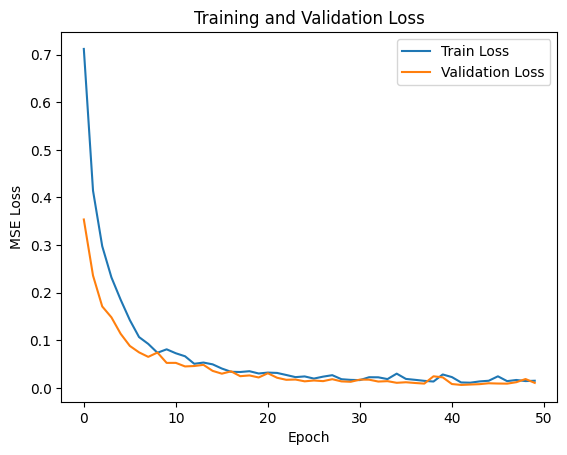

Overall Reconstruction MSE: 0.0163


In [83]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Load dataset
df = pd.read_csv('final_data.csv')

# Separate features and scale
features = df.drop(columns=['Food Name'])
scaler = StandardScaler()
X = scaler.fit_transform(features.values)

# Convert to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)

# Create dataset and split
dataset = TensorDataset(X_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

# Define autoencoder
class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        noisy = x + 0.1 * torch.randn_like(x)
        z = self.encoder(noisy)
        return self.decoder(z)

# Initialize model
input_dim = X.shape[1]
model = Autoencoder(input_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 50
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        data = batch[0]
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            data = batch[0]
            output = model(data)
            loss = criterion(output, data)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Plot losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Evaluate model
model.eval()
with torch.no_grad():
    reconstructed = model(X_tensor)
    mse = mean_squared_error(X_tensor.numpy(), reconstructed.numpy())
    print(f"Overall Reconstruction MSE: {mse:.4f}")

# Plot coefficient matrix (weights of first encoder layer)
weights = model.encoder[0].weight.data.numpy()

# plt.figure(figsize=(12, 8))
# sns.heatmap(weights, cmap='coolwarm', xticklabels=features.columns, yticklabels=[f"Enc_{i}" for i in range(weights.shape[0])])
# plt.title('Encoder First Layer Weights (Coefficient Matrix)')
# plt.xlabel('Input Features')
# plt.ylabel('Hidden Units')
# plt.show()


In [86]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics.pairwise import cosine_similarity
import torch.nn.functional as F

# Convert tensors to NumPy arrays
original = X_tensor.numpy()
reconstructed_np = reconstructed.numpy()

# Basic regression metrics
mse = mean_squared_error(original, reconstructed_np)
mae = mean_absolute_error(original, reconstructed_np)
rmse = np.sqrt(mse)
r2 = r2_score(original, reconstructed_np)

# Cosine similarity between original and reconstructed vectors (per sample)
cosine_sim_recon = np.mean([
    cosine_similarity([x], [y])[0][0]
    for x, y in zip(original, reconstructed_np)
])

# Cosine similarity in latent space
with torch.no_grad():
    encoded = model.encoder(X_tensor)
    encoded_np = encoded.numpy()
    latent_cosine_sim = np.mean([
        cosine_similarity([x], [y])[0][0]
        for x, y in zip(encoded_np, encoded_np)
    ])  # Note: this just shows overall similarity across encoded vectors

# Print all results
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Cosine Similarity (Reconstruction): {cosine_sim_recon:.4f}")



MSE: 0.0163
MAE: 0.0554
RMSE: 0.1278
R² Score: 0.9837
Cosine Similarity (Reconstruction): 0.9962
